## 0. 문제 발굴 단계

던전앤파이터에 대한 분석을 하기 위해서는 분석의 첫 단계인 문제를 기획하고 정의하는 단계를 세심하게 설계할 필요가 있습니다.
우선 던전앤파이터가 겪고 있는 문제들을 수집 할 수 있는 데이터에 대한 예시로 던파TV 유튜브 채널 댓글 데이터셋을 만들어서 분석할 수 있지만, 직접 분석을 해본 결과 던전앤파이터의 게임성과 방향성에 대한 비판적 의견을 제시하는 댓글보다는 원색적 비난을 하는 댓글의 비중이 커서 질이 좋은 데이터라고는 보기 힘듭니다.

유튜브 댓글에 비해서 건설적인 의견을 제시하고 유저의 입장에서 겪는 불편한 점을 직접적으로 피력하는 댓글 데이터로 '던전앤파이터 공식 홈페이지 개발자 노트 댓글 데이터'를 선택하였으며 이를 통하여 유저들이 생각하는 문제점과 방향성을 '발굴'하고 수집된 내용을 바탕으로 문제점들을 분석하고 문제에 대한 해결과정을 고민하여보겠습니다.

개발자노트는 최신 업데이트 3개만 분석하겠으며 그러는 이유는 최근 업데이트들이 모두 캐릭터 밸런싱에 대한 패치와 110렙 만렙확장과 105제 에픽 장비들의 밸런싱과 관련된 패치로 유저들이 가장 민감한 패치이기 때문입니다. 

## 1. Setup

In [7]:
from glob import glob
import pandas as pd
import numpy as np
from collections import Counter, defaultdict
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori
import networkx as nx

import re
from konlpy.tag import Mecab

plt.rc("font", family = "Malgun Gothic")
sns.set(font="Malgun Gothic", rc={"axes.unicode_minus":False})

## 2. Data Loading

2022년 4월 23일 기준으로 불러오는 데이터는 2월 10일, 3월 16일, 4월 20일 총 3가지 개발자 노트에 존재하는 댓글들을 직접 Selenium 패키지를 사용하여 수집하였습니다.

In [9]:
total = pd.DataFrame()
for i in glob("../../data/problem_mining/*.csv"):
    if "devnote" in i:
        tmp = pd.read_csv(i, index_col=[0])
        tmp["title"] = i.split("\\")[-1]
        total = pd.concat([total,tmp], axis=0)
total = total.reset_index(drop=True)
print(f"(총 댓글의 개수, 총 칼럼의 개수) : {total.shape}")
total.head()

(총 댓글의 개수, 총 칼럼의 개수) : (3350, 5)


,user_id,server,date,comment,title
0,알록달록산골,힐더,2022.02.16 (17:51),강이 만든 모든게 거의 십중팔구가 적폐라 손보는건 올바른 행동 아님?,20220210_devnote_comment.csv
1,알록달록산골,힐더,2022.02.16 (17:53),게임이 강레기가 디렉터일땐 죄다 운빨이라 게임이 카지노마냥 미쳐 돌아갔던데,20220210_devnote_comment.csv
2,방춘화,프레이,2022.02.16 (18:00),작년7-8월부터 이번년도 3월까지 보여줄게 계귀패치 패키지 확률 올린거 말고 없단 ...,20220210_devnote_comment.csv
3,알록달록산골,힐더,2022.02.16 (18:19),근데 솔직히 님 말씀도 맞는게 지금 할거 없는건 맞긴 함 띵진 오고 난 후나 지금이...,20220210_devnote_comment.csv
4,알록달록산골,힐더,2022.02.16 (18:34),진이계 왜 '이계를 아는자' 여격 APC가 안나오죠? 버그인가요?,20220210_devnote_comment.csv


불러온 데이터의 컬럼은 총 5가지로 각 컬럼의 설명은 다음과 같습니다.
- user_id : 댓글을 작성한 유저의 ID
- server : 댓글을 작성한 유저의 서버
- date : 댓글을 작성한 시간대
- comment : 댓글의 내용
- title : 댓글이 작성된 개발자 노트 일자

## 3. Simple EDA

C:\Users\park\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  from ipykernel import kernelapp as app


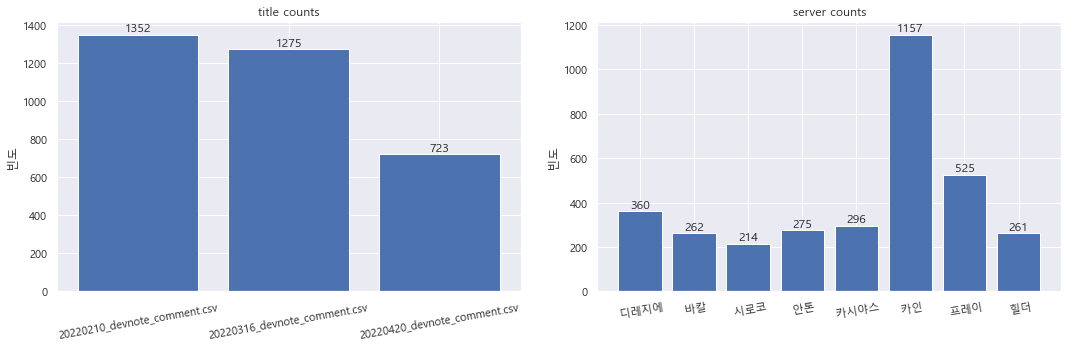

In [27]:
columns = ["title", "server"]
fig, axes = plt.subplots(1,2,figsize = (15,5))
axes = axes.ravel()

for idx, axis in enumerate(axes):
    tmp = total.groupby(columns[idx]).count().iloc[:,0]
    barplot = axis.bar(tmp.index, tmp.values)
    
    # Add counts above the two bar graphs
    for rect in barplot:
        height = rect.get_height()
        axis.text(rect.get_x() + rect.get_width() / 2.0, height, f'{height:.0f}', ha='center', va='bottom')
    
    axis.set_title(f"{columns[idx]} counts")
    axis.set_ylabel("빈도")
    axis.set_xticklabels (labels=tmp.index, rotation =10)
plt.tight_layout()
plt.show()

2022년 4월 24일 기준 2월 10일자 개발자노트의 댓글 개수는 1,352개, 3월 16일자 개발자노트는 1,275개, 4월 20일자 개발자노트는 723개의 댓글이 작성된 것을 알 수 가 있었으며 일별 댓글의 개수는 4월 20일자 개발자 노트가 가장 많았습니다.

댓글을 작성한 유저들이 속한 서버의 개수를 막대그래프로 시각화한 결과 인구수가 제일 많기로 유명한 카인서버의 유저가 가장 많은 댓글을 작성하였고 프레이 서버를 제외한 나머지 서버의 댓글수는 200~300개 정도로 나타나는 것을 알 수가 있었습니다.

## 4. Text Preprocessing

단어 빈도 분석과 같이 단어 수준의 분석이 필요한 경우 문장에서 필요치 않은 불용어를 제거하거나 특수문자를 지우는 등의 텍스트 전처리 과정을 거처야 하는데 해당 파트에서 어떠한 텍스트 전처리를 하였는지 정리하겠습니다.
1. html 태크 제거
2. 한국어, 숫자만 남도록 필터링
3. 반복되는 공백 제거
4. 반복되는 문장을 도배하여 분석에 악영향을 주는 댓글을 반복을 제거한 형태로 변환
5. 단어, 형태소 단위로 분절시켜주는 형태소 분석기 사용
6. 불용어 리스트 작성

In [157]:
def process(x):
    # 1. html 태그 제거
    x = re.sub("(<([^>]+)>)"," ", x)
    
    # 2. 한국어, 숫자만 남도록 필터링
    x = re.sub('[^ㄱ-ㅎ가-힣0-9]', " ", x)
    
    # 3. 반복되는 공백 제거
    x = re.sub("[ ]+", " ", x)
    x = x.strip()
    return x

# 4. 반복되는 문장을 도배하여 분석에 악영향을 주는 댓글을 반복을 제거한 형태로 변환
def repeats_press(string):
    for x in range(1, len(string)):
        substring = string[:x]
        if substring * (len(string)//len(substring))+(substring[:len(string)%len(substring)]) == string:
            return substring
    return string

# 5. 단어, 형태소 단위로 분절시켜주는 형태소 분석기 사용
mecab = Mecab(dicpath=r"C:/mecab/mecab-ko-dic")

# 6. 불용어 리스트 작성
stopwords = ["은", "는", "이", "가", "는데", "지만", "으로", "세요", 
             "에서", "습니다", "한다", "인데", "면서", "부터", "아요",
            "ㅋㅋ", "ㅋㅋㅋ", "합니다", "입니다", "으면", "네요", "다고",
            "정도", "이번", "라는", "라고", "다는"]

## 5. 개발자 노트별 단어 빈도 분석

100%|██████████████████████████████████████████████████████████████████████████████| 715/715 [00:00<00:00, 1418.93it/s]


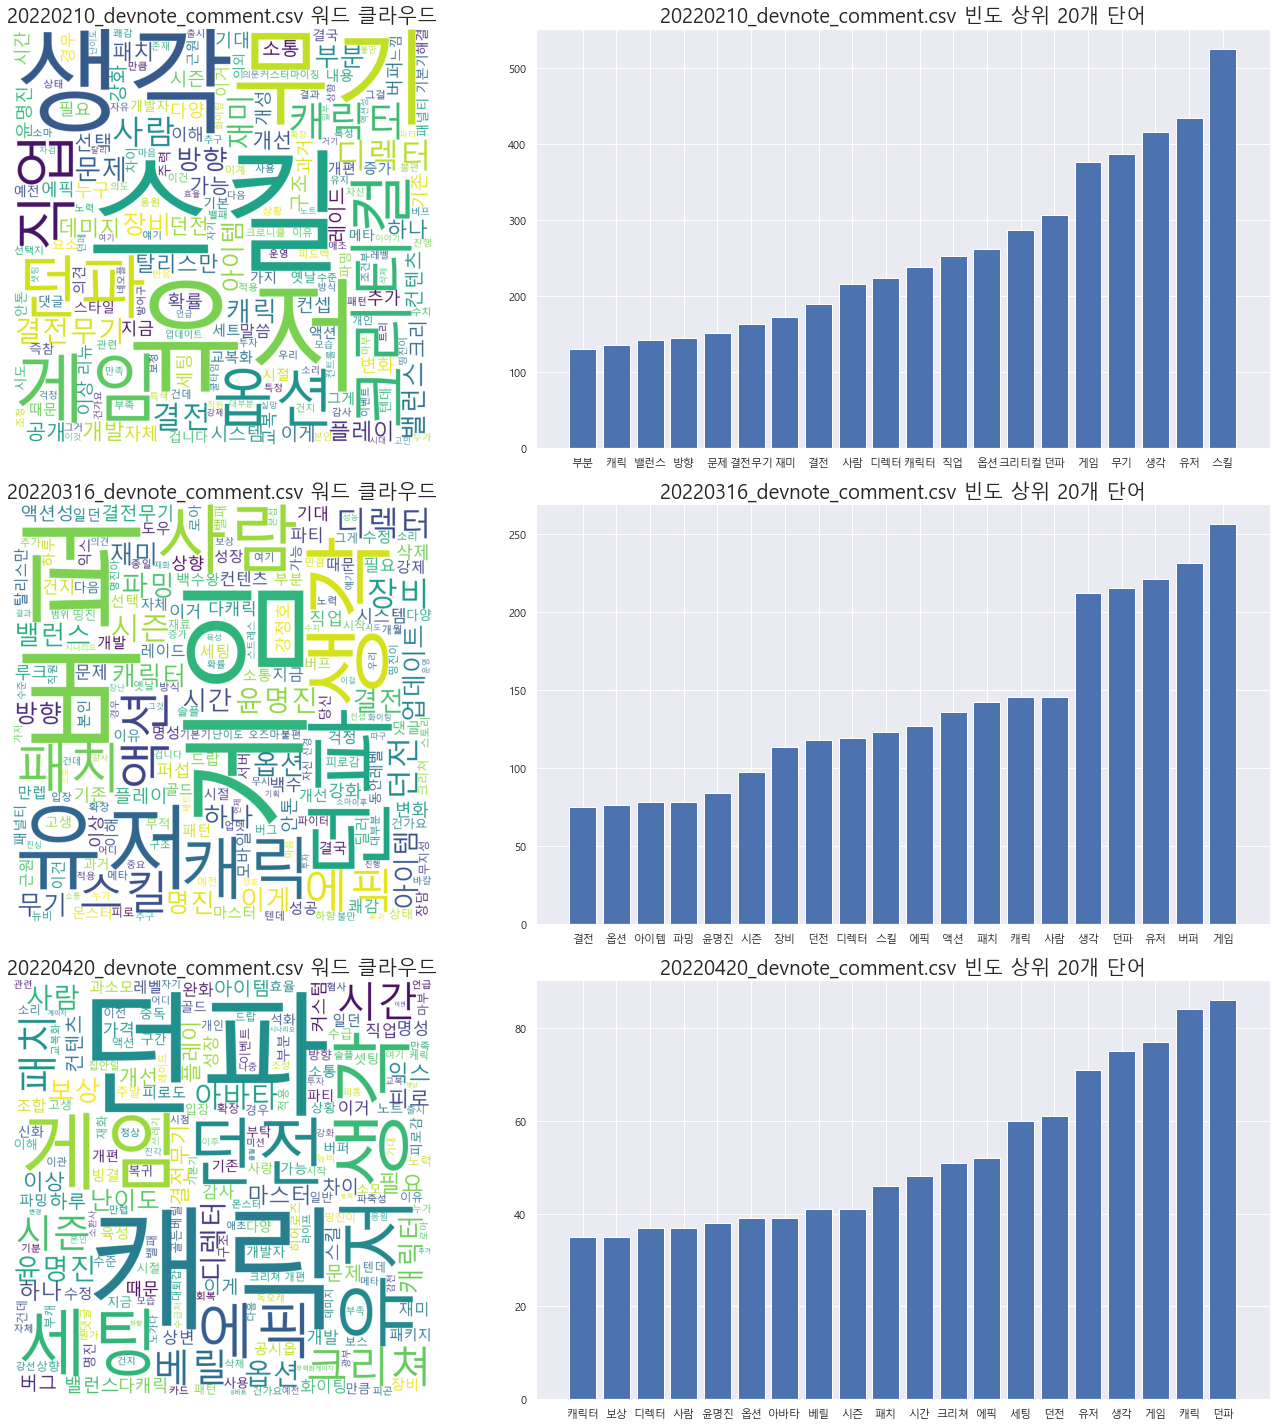

In [158]:
title_list = list(total.groupby("title").count().index)
fig, axes = plt.subplots(3, 2, figsize = (20, 20))
title_top20 = defaultdict()

for idx, axis in enumerate(axes):
    dev_note = total[total["title"] == title_list[idx]]
    dev_note = dev_note[dev_note["comment"].notnull()]
    tokens_list = []
    
    # 텍스트 전처리
    for sentence in tqdm(dev_note["comment"]):
        tmp = repeats_press(sentence)
        tmp = process(tmp)
        tmp = mecab.nouns(tmp)
        tmp = [i for i in tmp if i not in stopwords and len(i) != 1]
        tokens_list += tmp
    
    # 워드 클라우드
    count_tokens = Counter(tokens_list)    
    wc = WordCloud(font_path='malgun', width=800, height=800, scale=2.0, 
                           max_font_size=250, background_color='white')
    gen = wc.generate_from_frequencies(count_tokens)
    axis[0].imshow(gen)
    axis[0].set_title(f"{title_list[idx]} 워드 클라우드", fontsize = 20)
    axis[0].grid(False)
    axis[0].axis("off")
    
    # 막대 그래프
    top_word_20 = sorted(count_tokens.items(), key=lambda x : x[1], 
                         reverse= True)
    top_word_20 = top_word_20[:20][::-1]
    title_top20[title_list[idx]] = top_word_20
    words = []
    num = []
    for i,j in top_word_20:
        words += [i]
        num += [j]
    axis[1].bar(x=words, height=num)
    axis[1].set_title(f"{title_list[idx]} 빈도 상위 20개 단어", fontsize = 20)

      
plt.tight_layout()    
plt.show()

In [175]:
title_top20 = dict(title_top20)

words_list = []
for i in title_top20:
    words_list += [set(list(map(lambda x : x[0], title_top20[i])))]

intersection_word = list(words_list[0] & words_list[1] & words_list[2])
devnote_0210 = words_list[0] - words_list[1] - words_list[2]
devnote_0316 = words_list[1] - words_list[0] - words_list[2]
devnote_0420 = words_list[2] - words_list[0] - words_list[1]

print(f"3개의 패치노트에서 공통적으로 나온 단어 : {intersection_word}")
print(f"20220210 패치노트에서만 나온 단어 : {devnote_0210}")
print(f"20220316 패치노트에서만 나온 단어 : {devnote_0316}")
print(f"20220420 패치노트에서만 나온 단어 : {devnote_0420}")

3개의 패치노트에서 공통적으로 나온 단어 : ['유저', '게임', '디렉터', '캐릭', '생각', '사람', '옵션', '던파']
20220210 패치노트에서만 나온 단어 : {'문제', '밸런스', '무기', '방향', '직업', '결전무기', '재미', '크리티컬', '부분'}
20220316 패치노트에서만 나온 단어 : {'파밍', '아이템', '액션', '장비', '버퍼'}
20220420 패치노트에서만 나온 단어 : {'아바타', '크리쳐', '세팅', '베릴', '시간', '보상'}


개발자노트에서 빈도를 기반으로 많이 나온 단어들을 중심 키워드를 **{유저, 게임, 디렉터, 캐릭, 생각, 사람, 옵션, 던파}** 선정한 뒤 중심 키워드와 연관된 주변 키워드를 파악하기 위해서 Apriori 알고리즘을 적용한 연관 규칙 분석을 진행하겠습니다.

## 6. 연관 규칙 분석

support(지지도) - 동시발생행렬
- 전체 거래에서 특정 물품 A와 B가 동시에 거래되는 비중 해당 규칙이 얼마나 의미있는지 보여줌.
- 지지도 = P(A∩B) A와 B가 동시에 일어난 횟수 / 전체 거래 횟수

### 6.1 공통적으로 나온 키워드들 연관 규칙 분석

앞서 언급된 공통적으로 자주 나온 키워드는 **['유저', '게임', '디렉터', '캐릭', '생각', '사람', '옵션', '던파']** 로 정리가 가능하며 4월20일, 3월16일, 2월10일자 개발자 노트에 있는 댓글중에서 해당 키워드와 연관된 주변 키워드들을 시각화하겠습니다.

In [237]:
notnull_total = total[total["comment"].notnull()].reset_index(drop=True)
total_comment = []

# 텍스트 전처리
for sentence in tqdm(notnull_total["comment"]):
    tmp = repeats_press(sentence)
    tmp = process(tmp)
    tmp = mecab.morphs(tmp)
    tmp = [i for i in tmp if (len(i) > 1) and (i not in stopwords)]
    total_comment += [tmp]

100%|████████████████████████████████████████████████████████████████████████████| 3331/3331 [00:02<00:00, 1198.27it/s]


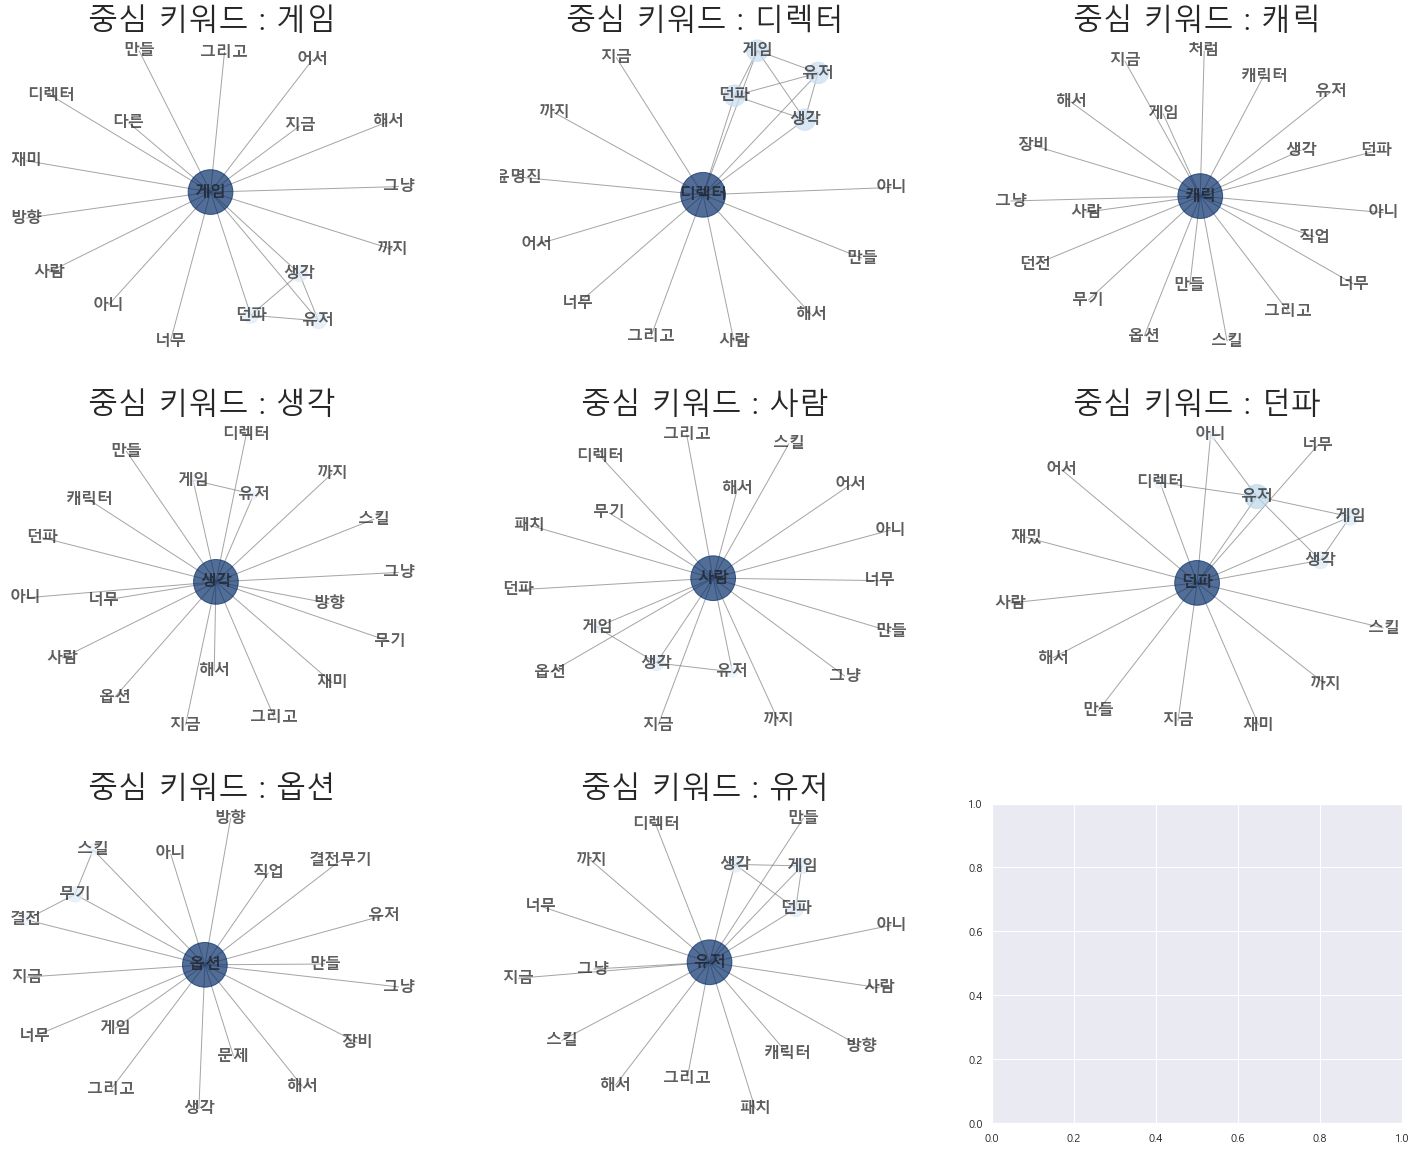

In [238]:
keywords = ['게임', '디렉터', '캐릭', '생각', '사람', '던파', '옵션', '유저']
nr = int(np.ceil(np.sqrt(len(keywords))))
fig, axes = plt.subplots(nr, nr, figsize = (25,20))
axes = axes.ravel()

for idx, axis in enumerate(axes):
    try:
        # 키워드가 포함된 댓글만 추출
        keyword = keywords[idx]
        key_include_list = []
        for i in total_comment:
            if keyword in i:
                key_include_list += [i]        

        # 단어 동시 출현 행렬 구축
        te = TransactionEncoder()
        te_result = te.fit(key_include_list).transform(key_include_list)
        df = pd.DataFrame(te_result, columns = te.columns_)        

        # Aprioir 알고리즘 기반 연관 규칙 분석
        itemset = apriori(df, min_support=0.1, use_colnames=True)
        itemset["length"] = itemset["itemsets"].apply(lambda x : len(x))

        # 중심 키워드 이외의 연관성 키워드 상위 20개 추출        
        length_2_set = itemset[itemset["length"] == 2]
        keyword_set_top20 =length_2_set.sort_values("support", ascending = False).iloc[:20]

        # 키워드 네트워크 기본 설정
        G = nx.Graph()
        ar = keyword_set_top20["itemsets"]
        G.add_edges_from(ar)
        
        # 연결중심성 기준의 degree_centrality는 각 node별로 직접 연결된 edge의 빈도기반의 weight 고려
        pr = nx.degree_centrality(G)
        nsize = np.array([v for v in pr.values()])
        nsize = 2000 * ((nsize - min(nsize)) / (max(nsize) - min(nsize)))

        # 키워드 네트워크 생성    
        nx.draw_networkx(G,font_size=16, node_color = list(pr.values()), node_size=nsize,
                         alpha=0.7,edge_color=".5",cmap=plt.cm.Blues, font_family = "Malgun Gothic",
                         ax = axis, font_weight = "bold")    
        axis.set_title(f"중심 키워드 : {keyword}", fontsize=30)
        axis.set_axis_off()
    except:
        pass

plt.show()    

Aprioir 알고리즘을 동시 발생 단어 빈도 기반의 support를 기준으로 관계성을 연결하였으며, 연관 규칙 분석을 support가 0.1 이상 일 때의 관계를 나타내고 있습니다.

연관 규칙 분석 진행하여 중심 키워드와 주변 키워드간의 관계를 동시출현 빈도를 기반으로 네트워크를 시각화한 결과 눈에 띄는 키워드들의 관계는 다음과 같습니다.
1. **{게임, 유저, 생각, 던파}**
2. **{결전, 무기, 스킬, 옵션}**

연관성을 지닌 주변 키워드끼리 어떠한 이유로 관계를 맺고 있는지 파악하기 위해서 해당 키워드들이 모두 포함된 댓글의 내용을 검색하여 내용을 파악하도록 하겠습니다.

centrality 참고 사이트 : https://frhyme.github.io/python-lib/network-centrality/

#### 6.1.1 연관성을 가지는 키워드가 담긴 댓글 내용 훑어보기

1) 첫 번째 연관성을 지닌 키워드는 **{게임, 유저, 생각 던파}** 로, 해당 키워드들은 다른 키워드들에 비해서 공통적으로 동시에 자주 나온 키워드이기도 하고 서로 연관 규칙 분석을 통하여 관련성도 있다고 판단된 키워드로 해당 키워드를 모두 포함한 댓글만을 뽑아서 확인해보겠습니다.

In [249]:
comment_num = len(notnull_total)
tmp_df = pd.DataFrame()
for idx in range(comment_num):
    comment = notnull_total["comment"][idx]
    if ("게임" in comment) and ("유저" in comment) and ("생각" in comment) and ("던파" in comment):
        tmp_df = tmp_df.append(notnull_total.iloc[idx, :])

현재 분석중인 개발자노트 댓글은 3종류이지만 과거 개발자노트의 내용은 차후 업데이트를 통하여 고쳐졌을지도 모르는 부분이기 때문에 최신의 문제점들을 수집하기 위해서 그 중에서 가장 최신 개발자 노트인 4월20일자 개발자 노트에서 언급되는 내용을 알아보도록하겠습니다.

In [296]:
filter_0420 = tmp_df[tmp_df["title"] == "20220420_devnote_comment.csv"]
for title, comment in filter_0420[["title", "comment"]].values:
    print(f"{title} : {comment}")
    print("\n")

20220420_devnote_comment.csv : ? 머리에 총맞으셨나요? 애초에 던파 쪽에서 과소모 상변이 최고라고 출시한게 아니고 유저들이 세팅 이거저거 다해보다가 mp과소모에상변끼는게 제일 쎄구나 라는걸 찾아서 낀거 아닌가요? 그렇다고해서 나머지 템들이 뒤질정도로 낮다고는 안느껴지는데 애초에 여러가지 세팅을 꾸릴 템들이 많은시점에 무슨무슨 조합을 해서 맞추면 제일 쎄다 이런건 다른 게임이고 정상적인 사고로 당연한거아님? 뭔;;ㅋㅋ 여러세팅중 당연 어느조합을 맞추면 생각보다 쎈것도 있을것이고 아닌것도 있는것인데 ㅋㅋㅋㅋㅋ


20220420_devnote_comment.csv : 기존 졸업자 입장에서 봤을 때도 뉴비&던린이분들을 위한 배려가 정말 느껴지지 않아서...최초 110렙 시작할 때의 아쉬운 부분이 많았던 것은 사실이나, 지속적인 A/S패치를 해주셔서 정말 감사합니다.

모두를 다 만족시킬 순 없겠지만, 유저와 개발진간의 '소통'의 결과물들이 패치로 나오는 것을 보면, 그래도 참 로아라는 게임에 감사하게 되는 유저입니다.

로아가 생각나는 '소통'에서, 던파만의 '소통'으로 발전하기를 진심으로 바라는 1인입니다.

개인적으로 이번 패치에도 불구하고 아쉬운 점이 있다면,

잡크리쳐 시세 폭등.
에픽 소울의 가치 떡락.
명성 신뢰도 대폭 하락.
신화 파밍의 어려움,
부케릭터 육성의 재미없음 (재미도 보람도 없는 1~100렙 육성 구간)

등이 있는 것 같네요.

아무쪼록 앞으로도 즐던할 수 있고, 많은 분들과 함께 던파할 수 있기를 바랍니다.


20220420_devnote_comment.csv : 분명 게임 방향성은 틀리지 않은거 같은데 뭔가 2% 부족한 느낌이 사라지지 않습니다
지금 파죽마 명성도 베릴 광부 10캐릭씩 돌려가며 시간 부어서 뚫는거보다 그냥 레전템 사서 쩔받고 누더기 걸치다가 넘어가는게 훨씬 빠른거 같은데 이런식으로 노가다보다 효율이 넘사벽 수준이면 굳이 베릴 캐서 한땀한땀 명성 올리는게 의미있을까라는 생각이 드네요.
그리고 직

확인한 결과 개발진을 칭찬하는 내용과 문제점을 제기하는 내용 2가지가 섞여있는 것으로 보이며 특히 문제점을 제기하는 경우 단순히 원색적인 비난이 아닌 구체적으로 어떠한 점이 문제인지 명확하게 밝히고 있기에 해당 문제 발굴 분석에서 의미있는 데이터라고 볼 수 있습니다.

4월 20일자 개발자 노트에 남긴 유저들의 댓글로 분석하여 나온 문제점을 정리하면 다음과 같습니다
- 크리쳐, 아바타 시세 폭등 문제
- 다캐릭 육성(5개 이상) 과정중 느끼는 캐릭터 육성 피로감

2) 두 번째 연관성을 지닌 키워드는 **{결전, 무기, 스킬, 옵션}** 로 마찬가지로 해당 키워드를 모두 포함한 댓글만을 뽑아서 확인해보겠습니다.

In [297]:
comment_num = len(notnull_total)
tmp_df = pd.DataFrame()
for idx in range(comment_num):
    comment = notnull_total["comment"][idx]
    if ("결전" in comment) and ("무기" in comment) and ("스킬" in comment) and ("옵션" in comment):
        tmp_df = tmp_df.append(notnull_total.iloc[idx, :])

filter_0420 = tmp_df[tmp_df["title"] == "20220420_devnote_comment.csv"]
for title, comment in filter_0420[["title", "comment"]].values:
    print(f"{title} : {comment}")
    print("\n")        

20220420_devnote_comment.csv : 방향성에 만족합니다.
하지만 딱 하나 불만인 점이 있는데, 결전무기의 캐릭마다의 효율성 차이가 좀 많이 납니다.
물론 결전무기의 옵션을 장비에서 잘 버무리면 목표한 성능이 나오긴 합니다만, 문젠 결전무기로 특화하는 스킬 혹은 플레이에서 효율성 차이가 캐릭마다 좀 많이 납니다.
결전무기 자체를 바꾸자고 하진 않습니다만, 결전무기가 강화하는 스킬 혹은 메커니즘의 기본 베이스가 너무 약해서 혹은 너무 불편해서 활용하기 어렵거나 비효율적인 직업들에 한정해서 결전무기와 연관된 스킬의 데미지 상향 혹은 메커니즘 완화가 있었으면 합니다.
결전무기의 옵션을 100% 활용해도 보편적인 세팅+근원 무기보다 동등 혹은 약하거나 엄청나게 불편한 플레이를 강요받는다면 결전무기를 사용 할 이유가 없으니까요.




키워드를 {결전, 무기, 스킬, 옵션}으로 바꾸어서 검색한 댓글의 내용을 정리하면 다음과 같습니다.
- 결전무기의 캐릭별 효율성 차이 문제

#### 6.1.2 선택된 댓글 분석 내용 정리

전체 개발자 노트의 댓글에서 공통적으로 나오는 단어(키워드)를 중심으로 연관 규칙 분석을 한 결과 연관성을 지닌 단어들의 관계성을 2가지 경우로 찾을 수 있었으며 첫 번째 관계는 **{게임, 유저, 생각, 던파}**이고 두 번째 관계는 **{결전, 무기, 옵션, 스킬}**입니다.

각 관계를 가진 키워드를 포함하고 있는 댓글을 검색한 결과 상당히 건설적인 문제제기를 하는 유저들의 댓글들을 선별할 수 있었으며 해당 댓글들에서 언급하는 던전앤파이터가 가지는 문제점은 다음과 같이 정리가 가능합니다.
1. 크리쳐, 아바타등의 아이템 가치 폭등
2. 다캐릭 육성으로 인한 과중한 육성 피로감을 호소하는 유저가 다수 존재
3. 결전무기의 캐릭별 효율성 문제

## 7. 분석내용 바탕의 문제점 해결 제안 방안

**1. 크리쳐, 아바타등의 아이템 가치 폭등 원인 분석**  

![image](https://user-images.githubusercontent.com/51338268/165587834-48f51e14-787e-41c5-afba-2ad108ada025.png)

![image](https://user-images.githubusercontent.com/51338268/165588051-967bb52e-1a5d-48cd-a3f0-a2082dea9ef2.png)

**원인**  
해당 문제의 원인은 2가지로 생각되며 첫 번째는 105제 에픽중 **'억류된 혼의 령주'**라는 아이템의 특성 때문이라고 생각됩니다. 왜냐하면 해당 에픽 장비의 효과는 부화한 크리쳐 보유수가 20개 이상일 시 모든속도 15%와 스킬 쿨타임 8%감소 라는 파격적인 옵션을 가졌는데 돈만 있으면 리스크가 없는 아이템이라서 많은 유저가 해당 조건을 충족하기 위해서 크리쳐를 많이 구매하면서 크리쳐의 수요가 급격히 상승하게 됩니다.

두 번째 원인은 개발진이 예고한 **'크리쳐 개편'**에도 영향을 받았다고 생각합니다. 왜냐하면 크리쳐 개편의 내용중 기존의 크리쳐를 강화시켜주는 크리처 각성이라는 시스템이 생기는데 각성을 하기 위해서는 크리쳐 소울이라는 재료가 필요하고 해당 소울을 획득하기 위해서는 크리쳐를 해체해야 하기 때문에 크리쳐의 수요량이 증가하게 됩니다.

2가지 요인에 의해서 상승하는 크리쳐의 수요를 미리 파악한 장사꾼들이 값싼 크리쳐들을 사재기하고 가격을 몇배로 올려서 재판매하면서 생기는 문제점이라고 생각합니다.  

**제안 사항**  
해당 문제는 크리쳐를 필요로 하는 사람에게 가지 않고 흔히 혐사꾼이라고 불리는 장사꾼에게 크리쳐의 매물이 묶이게 되면서 발생하는 문제라고 생각하며 이러한 과정은 옛날부터 반복되어온 내용입니다.  

하지만 최근 윤명진 디렉터님이 다시 디렉터로 부임하게 되면서 엠블렘들을 구입시 계정귀속화시키는 방법으로 장사꾼이 사도 되팔지 못하기 떄문에 이득을 남기지 못하도록 장사꾼들을 막는 방법을 시도하고 있으며 해당 방법이 효과가 있다고 판단하여 범위를 넓히고 있는 것으로 보입니다.  
크리쳐도 유저들이 필요한 물량은 정해져 있기 때문에 과거의 엠블렘과 비슷한 형태라고 볼 수 있으며, 앞선 방법과 같이 크리쳐 알 또한 구입시 계귀화를 시키면 장사꾼들이 개입하지 못하고 안정적인 가격을 찾아갈 것입니다.

**2. 다캐릭 육성으로 인한 과중한 육성 피로감을 호소하는 유저가 다수 존재 원인 분석**

**원인**  
과거 강정호 디렉터님이 던전앤파이터를 운영하던 시절부터 지금까지도 던전앤파이터는 한 계정이 많은 캐릭을 키우는 다캐릭 권장을 유저들에게 제안하고 있습니다. 하지만 최근 110렙 만렙확장 업데이트가 적용되며 많은 부분이 과거와는 달라졌고 캐릭터 육성 시스템 또한 과거와는 달라졌습니다. 특히 과거에는 핵앤슬래쉬느낌으로 아이템 파밍을 위해서 던전을 쉽고 빠르게 도는 구조였다면 최근 업데이트는 유저와 몬스터가 서로 패턴을 주고 받고 싸우는 액션성을 강조하는 형태로 변해가고 있습니다. 하지만 이러한 변화는 기존에 다캐릭 권장을 따라 핵앤슬래쉬에 익숙해진 유저들에게는 클리어 타임이 길어지면서 느끼는 부담감과 이에 따라 늘어나는 캐릭터별 육성 시간에 의한 피로감을 급격하게 느끼게 만들고 있습니다.

**제안 사항**  
해당 문제를 해결하기 위해서는 클리어 타임이 과거보다 너무 길어지면서 생기는 문제이지만 이 부분은 유저들이 시간이 지남에 따라서 더 좋은 장비를 맞춰가며 해결되는 문제라고 볼 수 있지만, 5개 이상의 다캐릭을 키우는 유저 입장에서는 캐릭마다 녹여야되는 피로도의 양이 집피로도 기준 156에 5캐릭이면 780이고 던전 한번에 피로도 8씩 소모하는 경우 약 98판을 돌아야 하는데 한판에 1분이 걸린다 치면 1시간 38분이 걸리게 되어 캐릭 수가 많아질 수록 유저들에게 부담이 될 수 있기 때문에 피로도 가속 시스템을 활용하도록 만드는 것이 좋다고 생각합니다.  
기존의 피로도 가속 시스템은 던전당 기존의 2배의 피로도를 소모하여 2배의 경험치와 재화를 얻는 시스템인데 유저들이 이 시스템을 좀 더 적극적으로 사용되려면 에픽 드랍률을 올려주는 방안도 좋다고 생각합니다.

**3. 결전무기의 캐릭별 효율성 문제**

이번에 110렙 만렙확장을 하며 새롭게 나온 105제 에픽 무기는 크게 근원무기, 결전무기로 나뉩니다.  
근원무기와 결전무기의 딜적인 측면에서 차이는 거의 없도록 설계하였다고 들었으며 각 무기의 특징을 설명하자면 근원무기는 데미지와 스킬레벨이 상승하며 전체적인 밸런스를 갖춘 무기이고 결전무기의 경우 각 케릭터마다의 개성을 살릴 스킬들에 직접적인 변화를 주어 유저들에게 참신한 재미를 주는 독특한 무기입니다. 

하지만 결전무기는 운영진이 살리려는 계획의도와 유저가 원하는 방향이 다르면 근원무기를 선택하게될 가능성이 높으며, 캐릭터의 이해도가 낮은 상태로 패치를 진행하면 오히려 스킬 구조 시스템의 효율성이 떨어질 뿐만 아니라 유저들이 게임을 즐기는 재미까지 감소하게 되기 때문에 지속적으로 유저들이 사용하는 105제 무기의 비율을 분석하여 결전무기를 사용하지 않는 이유를 모니터링 해야 합니다.

직업별로 다른 효과를 가진 결전무기를 유저들이 사용하고나서 2022년 4월 26일을 기준으로 한 던파OFF 사이트의 유저들이 착용한 무기의 비율에 대한 데이터를 수집하여 각 직업별로 결전무기를 선호하는지 근원무기를 선호하는지 비교한 뒤 근원무기를 압도적으로 선호하는 직업군 중에서 상위 5개를 뽑아서 결전무기를 선택하지 않는 이유를 분석하겠습니다.

In [2]:
weapon_105 = pd.read_csv("./20220426_weapon_count.csv")
tmp = []
for name in weapon_105["weapon_name"]:
    if "결전의" in name:
        tmp += ["결전 무기"]
    else:
        tmp += ["근원 무기"]
weapon_105["new_name"] = tmp
result = weapon_105["weapon_count"]
result.index = weapon_105["new_name"] + " " + weapon_105["job"]
result = pd.DataFrame(result.sum(level=0))
result = result.reset_index()

result["job"] = result["index"].apply(lambda x : " ".join(x.split()[2:]))
result["weapon"] = result["index"].apply(lambda x : x.split()[0])
result = result.pivot_table(index="job", values="weapon_count", columns="weapon")

result["결전 비율"] = result["결전"] / (result["결전"] + result["근원"] )
result["근원 비율"] = result["근원"] / (result["결전"] + result["근원"] )
result["우세한 무기"] = np.where(result["결전"] > result["근원"], "결전", "근원")
result.head()

weapon,결전,근원,결전 비율,근원 비율,우세한 무기
job,,,,,
가이아,584,793,0.424110,0.575890,근원
갓파더,834,899,0.481246,0.518754,근원
검신,2354,6269,0.272991,0.727009,근원
검제,4711,5550,0.459117,0.540883,근원
그랜드 마스터,780,389,0.667237,0.332763,결전


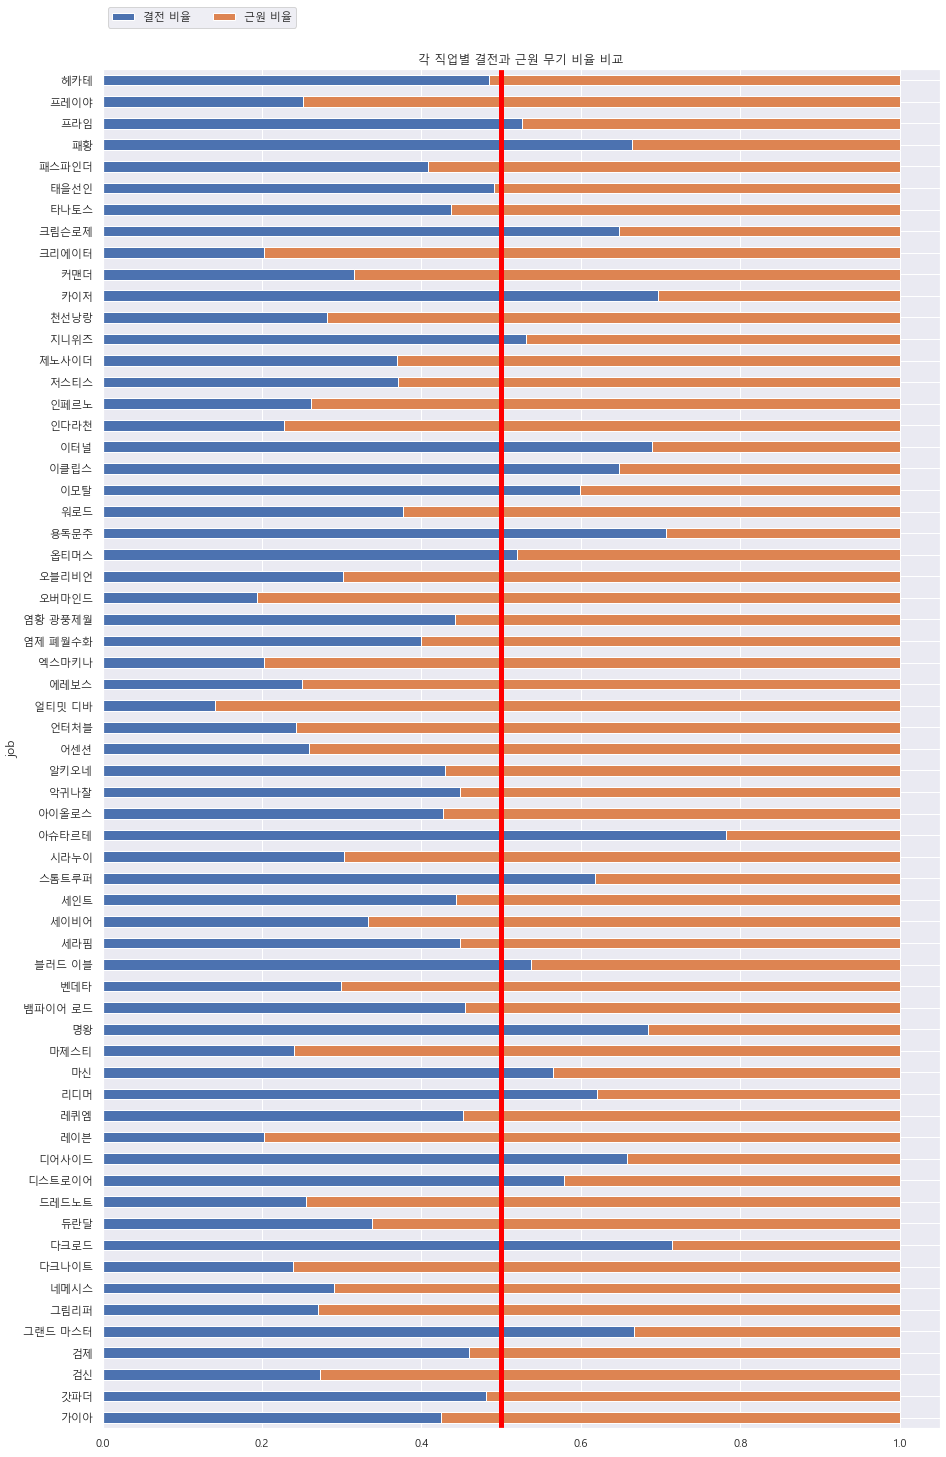

In [62]:
result[["결전 비율", "근원 비율"]].plot(kind="barh", stacked=True, figsize = (15, 25))
plt.axvline(x=0.5, c = "red", linewidth=5)
plt.legend(loc = "upper left", ncol = 2, bbox_to_anchor=(0, 1.05))
plt.title("각 직업별 결전과 근원 무기 비율 비교")
plt.show()

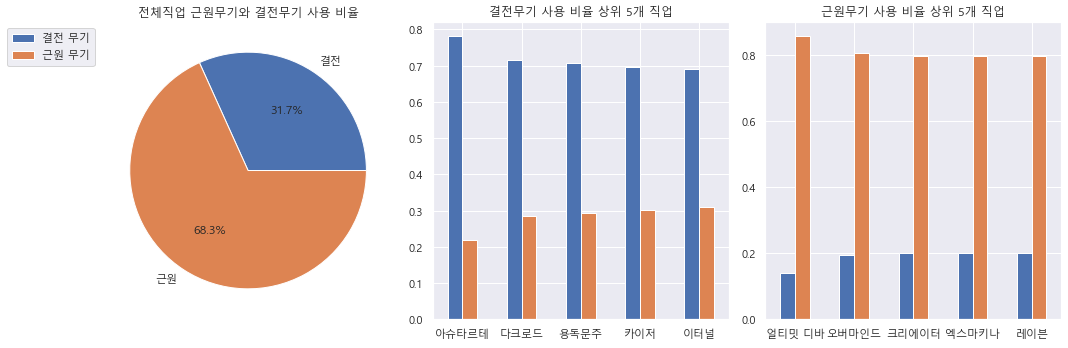

In [56]:
fig, axes = plt.subplots(1,3, figsize =(15, 5))
# 전체 직업 근원무기와 결전무기 비율
weapon_ratio = result.groupby("우세한 무기").count().iloc[:,0]
weapon_ratio.plot(kind="pie", ax = axes[0], autopct='%.1f%%')
axes[0].set_title("전체직업 근원무기와 결전무기 사용 비율")
axes[0].axis("off")
axes[0].legend(["결전 무기", "근원 무기"], bbox_to_anchor=(0, 1))

# 결전무기 사용 직업 상위 5개
skill_top_5 = result.sort_values("결전 비율",ascending=False).iloc[:5][["결전 비율", "근원 비율"]]
skill_top_5.plot(kind = "bar", ax = axes[1])
axes[1].set_title("결전무기 사용 비율 상위 5개 직업")
axes[1].set_xticklabels(labels = skill_top_5.index,rotation = 0)
axes[1].legend().remove()
axes[1].set_xlabel("")

# 근원무기 사용 직업 상위 5개
skill_top_5 = result.sort_values("근원 비율",ascending=False).iloc[:5][["결전 비율", "근원 비율"]]
skill_top_5.plot(kind = "bar", ax = axes[2])
axes[2].set_title("근원무기 사용 비율 상위 5개 직업")
axes[2].set_xticklabels(labels = skill_top_5.index,rotation = 0)
axes[2].legend().remove()
axes[2].set_xlabel("")

plt.tight_layout()
plt.show()

결전무기보다 근원무기를 압도적으로 채용하는 직업군 상위 5개는 '얼티밋 디바', '오버마인드', '크리에이터', '엑스마키나', '레이븐'으로 나왔으며 각 직업들이 결전무기를 기피하는 원인을 던파 공식 홈페이지에서 선정한 직업별 가이드 게시물에서 찾아보겠습니다.

**[얼티밋 디바](https://df.nexon.com/df/community/dnfboard?page=1&title_type=3&view_type=all&mode=view&no=2662366&job=1&grow_type=4)**  
얼티밋 디바의 결전무기는 스킬들을 사용할 수록 쌓이는 새로운 콤보 시스템을 도입하여 일정 수준 이상의 콤보를 쌓으면 쿨타임 감소라는 보상을 받는 구조인데 이 구조는 숙련된 유저들에게는 문제가 되지 않지만 이제 막 시작한 신입 유저들에게는 사용 난이도가 있는 무기이기 때문에 기피하고 있다고 생각되며 또한, 신뢰성 있는 내용은 아니지만 나무위키의 내용에 따르면 근원무기에 비하여 스킬 공격력 증가와 피해 증가량의 수치가 상대적으로 낮고, 해당 무기를 사용하면서 발생하는 제약때문에 다른 장비와의 시너지를 기대하기 어렵다는 원인이 있다고 합니다.

**[오버마인드](https://df.nexon.com/df/community/dnfboard?page=3&title_type=3&view_type=all&mode=view&no=2660494&job=3&grow_type=1)**  
오버마인드의 결전무기는 기존의 스킬을 저장하여 짧은 쿨타임으로 만들어서 스킬을 난사하도록 구조를 개선시켜주는 장비인데 쿨타임이 감소하면서 데미지까지 너무 크게 감소하다 보니 기존의 스킬을 사용할 때에 비해서 스킬 효율성이 크게 떨어지게 만들어서 오버마인드 유저들이 결전무기를 기피하는 것으로 보입니다.

**[크리에이터](https://df.nexon.com/df/community/dnfboard?page=3&title_type=3&view_type=all&mode=view&no=2657187&job=10&grow_type=0)**  
가이드 게시물에 따르면 크리에이터의 결전무기는 극초기에 굉장히 효율이 떨어졌기에 인기가 없어서 대부분 근원무기를 선택하였지만 현재 어느정도 패치가 이루어져서 쓸 수 있게 되었다고 하지만, 막대 그래프에서 근원무기의 비율이 높은 이유는 초기의 인식 때문에 많은 크리에이터 유저가 근원무기를 선택한 것으로 보입니다.

**[엑스마키나](https://www.youtube.com/watch?v=VVIXNAbCV1Y)**  
엑스마키나의 경우 당근로그 유튜브 채널을 참고하였으며 해당 영상에서 언급하는 결전무기의 문제점은 캐릭터의 특성상 '워커'라는 스킬에 탑승하고 내리면서 스킬을 사용해야하는데 결전 무기 옵션에 있는 다른 스킬을 캔슬해야 쌓이는 스택 시스템을 최대로 쌓아서 활용하기 어렵다는 것이 가장 큰 문제로 꼽았으며 이에 따라 차라리 근원 무기를 선택하는 것이 좋다는 의견을 비추고 있습니다.

**[레이븐](https://namu.wiki/w/%EB%8D%98%EC%A0%84%20%EC%95%A4%20%ED%8C%8C%EC%9D%B4%ED%84%B0/%EC%95%84%EC%9D%B4%ED%85%9C/%EB%A6%AC%EB%B3%BC%EB%B2%84#s-6.20)**  
레이븐의 결전무기의 옵션은 더블 건호크 사이에 사용한 스킬의 쿨타임을 줄여주도록 만들어 스킬을 더 많이 넣을 수 있도록 더블 건호크를 강화시켜주는 무기입니다.
하지만 실제로 사용할 때, 더블 건호크를 사용하고 스킬 쿨타임을 줄일 만한 스킬의 개수가 굉장히 적고 만약 더블 건호크를 다시 잡는데 실패하면 옵션의 효과를 날리게 되어서 리스크가 굉장히 높은 무기인데 반해 리턴이 적다고 판단한 유저들이 근원무기를 선택하고 있는 상태입니다.

**제안 사항**  
해당 문제는 지속적으로 각 직업의 유저들이 말하는 정당성 있는 피드백을 받아야 하는 부분으로 문제를 완전히 해결한다기 보다는 계속 유저들의 의견을 수집하고 수집된 내용을 바탕으로 퍼스트서버에서 피드백을 받으며 보수하는 관점으로 접근해야 한다고 생각합니다.